In [1]:
import dataLoader as D
import util as U
import sys
import torch

sys.path.append('/Users/abdielfer/RNCanWork/DL4Flood/')
# subfolder import:
from model_set.models import UNetFlood
trn_listPath = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/template_project_feat1_min-annot1_trn.csv'
val_listPath = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/template_project_feat1_min-annot1_val.csv'

args = {'savepath':trn_listPath, 'batch_size': 1, 'num_workers': 0,'drop_last':False}

train_set = D.customDataloader(D.customDataSet(trn_listPath, True),args).getDataloader()
val_set = D.customDataloader(D.customDataSet(val_listPath, True),args).getDataloader()

rasterPath = '/Users/abdielfer/RNCanWork/GDLData/TestTiling/template_project/trn/VilleGatineau-1/images/ON_VilleGatineau_440125_777821867_5038038_55970885.tif'

In [2]:
import models_trainer
import losses as L
from losses import iou_binary as iouB
from torch.optim import Adam 

In [4]:
model = UNetFlood(1,1)
loss_fn = L.lovasz_hinge
optimizer = Adam(model.parameters(), lr = 0.0001)
metric = iouB

trainer = models_trainer.models_trainer(model,loss_fn,optimizer,metric)
trainer.set_loaders(train_set,val_set)

In [5]:
trainer.train(100)

Epoch 0 ........ ->


image to model input shape torch.Size([1, 1, 380, 380])


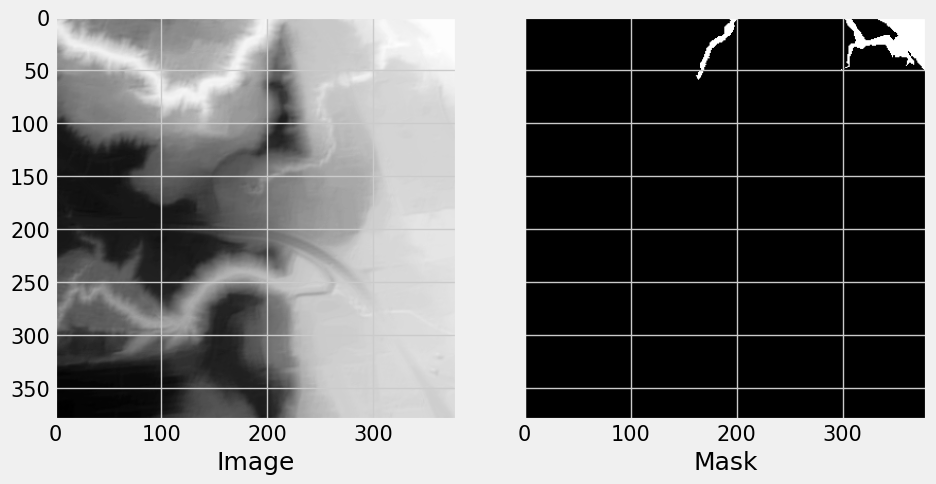

In [11]:
item = next(iter(val_set))
imag = item[0]
mask = item[1]
print('image to model input shape',imag.shape)
with torch.no_grad():
    model.eval()
    Y_hat = model(imag)
    model.train()
U.plotImageAndMask(Y_hat[0][0], mask[0][0])

In [13]:
import torch as T
from torch.autograd import Variable

In [16]:
flated = Y_hat[0][0].view(-1)
signs = 2. * mask[0][0].float() - 1.
print(Y_hat[0][0][0:10,300:310])
print(signs[0:10,300:310])
print(signs.shape)
errors = (1. - Y_hat[0][0] * Variable(signs))
print(errors[1:10,1:10])
# U.plotImageAndMask(signs, errors)

tensor([[0.4311, 0.4325, 0.4342, 0.4351, 0.4347, 0.4351, 0.4361, 0.4378, 0.4415,
         0.4434],
        [0.4312, 0.4323, 0.4331, 0.4331, 0.4329, 0.4337, 0.4356, 0.4370, 0.4413,
         0.4424],
        [0.4315, 0.4323, 0.4331, 0.4335, 0.4336, 0.4345, 0.4361, 0.4378, 0.4415,
         0.4428],
        [0.4321, 0.4332, 0.4344, 0.4353, 0.4360, 0.4370, 0.4389, 0.4403, 0.4414,
         0.4431],
        [0.4325, 0.4331, 0.4340, 0.4351, 0.4363, 0.4377, 0.4397, 0.4417, 0.4423,
         0.4437],
        [0.4330, 0.4332, 0.4338, 0.4354, 0.4368, 0.4378, 0.4399, 0.4428, 0.4441,
         0.4444],
        [0.4331, 0.4339, 0.4346, 0.4357, 0.4373, 0.4391, 0.4406, 0.4425, 0.4440,
         0.4449],
        [0.4328, 0.4339, 0.4345, 0.4352, 0.4368, 0.4393, 0.4409, 0.4420, 0.4433,
         0.4445],
        [0.4316, 0.4326, 0.4338, 0.4346, 0.4354, 0.4372, 0.4398, 0.4419, 0.4427,
         0.4433],
        [0.4301, 0.4310, 0.4323, 0.4336, 0.4340, 0.4350, 0.4380, 0.4411, 0.4423,
         0.4426]])
tensor([[

In [ ]:
####   Apply sigmoid to the output image to compare with Mask...IMportant!!!!
y_hatSigmoided = torch.sigmoid(Y_hat[0][0])
U.plotImageAndMask(y_hatSigmoided, mask[0][0])

In [ ]:
### Visualize all batch image-mask pairs. 
# NOTE :   img, mask = next(iter(train_set))
i = 0
j = 0
for batch in train_set:
    for item in batch:
        print(f"Bathc {i}, item {j}")
        print('item',item.shape)
        j +=1
        
    # U.plotImageAndMask(batch[0][0],batch[1][0])
    i+=1
    j=0  
    print("_______") 


In [ ]:
## Ref: 

from typing import Iterable, List
import torch
import matplotlib.pyplot as plt

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='gray')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

In [ ]:

from pathlib import  Path
import xarray as xr
import matplotlib.pyplot as plt

root = Path('dset-s2')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()
     

idx = 0
img = xr.open_rasterio(train_imgs[idx])
mask = xr.open_rasterio(train_masks[idx])
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/3000
axs[0].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap='Blues')